## Setup

In [1]:
!pip install -U googlemaps

Requirement already up-to-date: googlemaps in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (4.4.2)
Requirement not upgraded as not directly required: requests<3.0,>=2.20.0 in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (from googlemaps) (2.20.0)
Requirement not upgraded as not directly required: idna<2.8,>=2.5 in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (from requests<3.0,>=2.20.0->googlemaps) (2.6)
Requirement not upgraded as not directly required: chardet<3.1.0,>=3.0.2 in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (from requests<3.0,>=2.20.0->googlemaps) (3.0.4)
Requirement not upgraded as not directly required: urllib3<1.25,>=1.21.1 in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (from requests<3.0,>=2.20.0->googlemaps) (1.23)
Requirement not upgraded as not directly required: certifi>=2017.4.17 in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (from req

In [2]:
import pandas as pd
import pickle
import googlemaps
from collections import defaultdict

In [3]:
df = pd.read_csv('./inmates.csv')

In [4]:
df.head()

,Unnamed: 0,actRelDate,age,faclCode,faclName,faclType,faclURL,inmateNum,inmateNumType,nameFirst,nameLast,nameMiddle,projRelDate,race,region,releaseCode,sex,suffix
0,0,01/14/1985,71.0,SDC,San Diego,MCC,/locations/institutions/sdc/,77709-098,NaN,MARCOS,ALVAREZ,OLIVO,NaN,White,98,R,Male,NaN
1,1,04/25/2018,57.0,SEA,Seagoville,FCI,/locations/institutions/sea/,31526-001,NaN,PATRICK,MINGA,R,NaN,White,1,R,Male,NaN
2,2,12/09/2013,28.0,NYM,New York,MCC,/locations/institutions/nym/,64418-054,NaN,DEMETRIUS,SCOTT,NaN,NaN,Black,54,R,Male,NaN
3,3,08/10/2007,44.0,BSC,Big Spring,CI,/locations/ci/bsc/,27208-180,NaN,ADRIAN,VALDEZ-VISCAINO,RENE,NaN,White,180,R,Male,NaN
4,4,NaN,38.0,NaN,IN TRANSIT,NaN,NaN,82108-279,NaN,JOSE,FAZ-TORRES,ANDRES,UNKNOWN,White,279,NaN,Male,NaN


In [5]:
# want inmateNum into region num and id num
df['inmateId'] = df['inmateNum'].apply(lambda s: int(s.split('-')[0]))

## Background and Schema

### `faclType`

| Security | Code | Type |
| --- | --- | --- |
| Minimum | FPC | Federal Prison Camp |
| Minimum | SPC | Satellite Prison Camp |
| Low | FCI | Federal Correctional Institutions |
| Low | FSL | Federal Satellite Low Security |
| Medium | FCI | Federal Correctional Institutions |
| High | USP | United States Penitentiaries |
| Complex | FCC | Federal Correctional Complexes |
| Administrative | MCC | Metropolitan Correctional Centers |
| Administrative | MDC | Metropolitan Detention Centers |
| Administrative | FDC | Federal Detention Centers |
| Administrative | FMC | Federal Medical Center |
| Administrative | FTC | Federal Transfer Center |
| Administrative | MCFP | Medical Center for Federal Prisioners |
| Administrative | ADX | Administrative-Maximum Security Penitentiary |
| Administrative | RO | Regional Office |
| Administrative | RRM | Residential Reentry Management Centers |


In [6]:
df['faclType'].unique()

array(['MCC', 'FCI', 'CI', nan, 'RRM', 'FMC', 'USP', 'FDC', 'MDC', 'RO',
       'FPC', 'MCFP', 'FTC'], dtype=object)

### Register Number Codes
> The United States Marshals Service and the Federal Bureau of Prisons assigns a eight digit "Register Number" to all offenders in the following format:  XXXXX-0XX.   The last three digits signify the district wherein the offender was arrested and or processed into the system.  In large districts, where over 100,000 people have been processed, the '"0" is replaced with a "1". [[source](http://www.fedcure.org/information/RegisterNumberCodes.shtml#.XvawAmpKhb8)]

We thus expect the region numbers to be distributed with a far right tail.

In [7]:
df['region'].hist()

To actually determine the regional distribution, we should remove the first digit from the region.

In [8]:
df['_region'] = df['region']
df['regionNum'] = df['_region'].apply(lambda s: int(int(s) % 100))
df.head()

,Unnamed: 0,actRelDate,age,faclCode,faclName,faclType,faclURL,inmateNum,inmateNumType,nameFirst,...,nameMiddle,projRelDate,race,region,releaseCode,sex,suffix,inmateId,_region,regionNum
0,0,01/14/1985,71.0,SDC,San Diego,MCC,/locations/institutions/sdc/,77709-098,NaN,MARCOS,...,OLIVO,NaN,White,98,R,Male,NaN,77709,98,98
1,1,04/25/2018,57.0,SEA,Seagoville,FCI,/locations/institutions/sea/,31526-001,NaN,PATRICK,...,R,NaN,White,1,R,Male,NaN,31526,1,1
2,2,12/09/2013,28.0,NYM,New York,MCC,/locations/institutions/nym/,64418-054,NaN,DEMETRIUS,...,NaN,NaN,Black,54,R,Male,NaN,64418,54,54
3,3,08/10/2007,44.0,BSC,Big Spring,CI,/locations/ci/bsc/,27208-180,NaN,ADRIAN,...,RENE,NaN,White,180,R,Male,NaN,27208,180,80
4,4,NaN,38.0,NaN,IN TRANSIT,NaN,NaN,82108-279,NaN,JOSE,...,ANDRES,UNKNOWN,White,279,NaN,Male,NaN,82108,279,79


In [9]:
df.groupby('regionNum').count().head()

,Unnamed: 0,actRelDate,age,faclCode,faclName,faclType,faclURL,inmateNum,inmateNumType,nameFirst,nameLast,nameMiddle,projRelDate,race,region,releaseCode,sex,suffix,inmateId,_region
regionNum,,,,,,,,,,,,,,,,,,,,
0,873,759,872,765,873,765,765,873,0,873,873,308,114,873,873,759,873,16,873,873
1,1238,1097,1234,1152,1238,1152,1152,1238,0,1238,1238,929,141,1238,1238,1097,1238,69,1238,1238
2,212,176,212,202,212,202,202,212,0,212,212,146,36,212,212,176,212,11,212,212
3,889,752,889,825,889,825,825,889,0,889,889,674,137,889,889,752,889,61,889,889
4,10241,9196,10235,8905,10241,8905,8905,10241,0,10241,10241,4646,1045,10241,10241,9196,10241,153,10241,10241


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6e696b0b00>]],
      dtype=object)

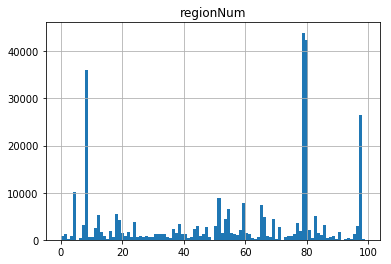

In [10]:
df.hist('regionNum', bins=101)

In [11]:
df['gmap_query'] = df['faclName'] + ' ' + df['faclType']

In [12]:
queries = list(set(df['gmap_query']))

loading the hand compiled locations of prisons

In [13]:
with open('./prisonResponses.p', 'rb') as fp:
    responses = pickle.load(fp)

In [14]:
responses[3]

('Tucson USP',
 [{'address_components': [{'long_name': '9300',
     'short_name': '9300',
     'types': ['street_number']},
    {'long_name': 'South Wilmot Road',
     'short_name': 'S Wilmot Rd',
     'types': ['route']},
    {'long_name': 'Tucson',
     'short_name': 'Tucson',
     'types': ['locality', 'political']},
    {'long_name': 'Pima County',
     'short_name': 'Pima County',
     'types': ['administrative_area_level_2', 'political']},
    {'long_name': 'Arizona',
     'short_name': 'AZ',
     'types': ['administrative_area_level_1', 'political']},
    {'long_name': 'United States',
     'short_name': 'US',
     'types': ['country', 'political']},
    {'long_name': '85756', 'short_name': '85756', 'types': ['postal_code']}],
   'formatted_address': '9300 S Wilmot Rd, Tucson, AZ 85756, USA',
   'geometry': {'location': {'lat': 32.0847301, 'lng': -110.865276},
    'location_type': 'ROOFTOP',
    'viewport': {'northeast': {'lat': 32.0860790802915,
      'lng': -110.8639270197085}

In [15]:
def getRow(entry):
    name = entry[0]
    response = entry[1]
    try:
        pair = response[0]['geometry']['location']
        return (name, pair['lat'], pair['lng'])
    except:
        print(name)

In [16]:
coords = pd.DataFrame([getRow(e) for e in filter(lambda r: r[0] != 'nan', responses)])
coords.columns = ['gmap_query', 'lat', 'lng']

Southeast RO


In [17]:
coords.sort_values('lng')

,gmap_query,lat,lng
84,Honolulu FDC,21.333378,-157.928237
162,Sheridan FCI,45.084014,-123.381623
68,Seattle RRM,47.422035,-122.301491
85,SeaTac FDC,47.422309,-122.301146
135,Dublin FCI,37.717742,-121.894898
130,Sacramento RRM,38.583440,-121.498844
124,Atwater USP,37.386069,-120.558576
155,Lompoc USP,34.676268,-120.505549
15,Lompoc FCI,34.677439,-120.497665
77,Mendota FCI,36.731908,-120.392343


In [18]:
pdf = df.merge(coords, on = 'gmap_query')

## Analysis

In [19]:
md_lat = coords['lat'].median()
md_lng = coords['lng'].median()

def getNorthSouth(lat):
    if lat > md_lat:
        return 'North'
    return 'South'

def getEastWest(lng):
    if lng < md_lng:
        return 'West'
    return 'East'

In [20]:
pdf['orientation_y'] = pdf['lat'].apply(getNorthSouth)

In [21]:
pdf['orientation_x'] = pdf['lng'].apply(getEastWest)

In [22]:
pdf[['orientation_x', 'orientation_y', 'gmap_query']]

,orientation_x,orientation_y,gmap_query
0,West,South,San Diego MCC
1,West,South,San Diego MCC
2,West,South,San Diego MCC
3,West,South,San Diego MCC
4,West,South,San Diego MCC
5,West,South,San Diego MCC
6,West,South,San Diego MCC
7,West,South,San Diego MCC
8,West,South,San Diego MCC
9,West,South,San Diego MCC
